In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

import warnings

import commons

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')


In [2]:
dataset_path = "..//datos//"
abnb_users_curated = "modified_train_users.csv"

In [3]:

users_df = pd.read_csv( dataset_path + abnb_users_curated)

In [4]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(users_df),' users.')

The dataset contains:  121070  users.


In [5]:
users_df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,1,38.0,1,0,5,...,6,2,3,7,0,0.0,0.0,1,1,False
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,6,2,6,14,1,0.0,0.0,1,1,True
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,6,2,3,13,2,0.0,0.0,1,1,True
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,6,2,3,7,1,0.0,0.0,1,1,True
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,6,2,3,30,1,0.0,0.0,1,1,True


Vamos a comenzar a trabajar con un subconjunto de usuarios.  
En este caso, usuarios que hicieron reserva (pero que no fueron a USA)  
Como esto no sirvio, vamos a armar destino USA, destino Europa, destino Resto

In [6]:
country_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

europe_set = {3,5,6,7,8,9,10}
north_america_set = {4}
oceania_set = {11}
usa_set = {1}
other_set = {2}

europe_region = 0
north_america_region = 1
oceania_region = 2
usa_region = 3
other_region = 4
no_region = 5

def assign_region( country ):
    if country in europe_set:
        return europe_region
    
    if country in north_america_set:
        return north_america_region
    
    if country in oceania_set:
        return oceania_region
    
    if country in usa_set:
        return usa_region

    if country in other_set:
        return other_region
    
    return no_region
    

In [7]:
users_df['region_destination'] = users_df['country_destination'].apply(lambda x: assign_region(x))

users_who_booked = users_df[ users_df['has_booked'] == True ]

print( "Number of records: ", len(users_who_booked))
users_who_booked.head()

Number of records:  66836


,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked,region_destination
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,2,6,14,1,0.0,0.0,1,1,True,3
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,2,3,13,2,0.0,0.0,1,1,True,4
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,2,3,7,1,0.0,0.0,1,1,True,3
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,2,3,30,1,0.0,0.0,1,1,True,3
5,7,0d01nltbrs,1262476800,1262546345,1263340800,0,47.0,0,0,5,...,2,3,30,1,0.0,0.0,1,1,True,3


In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)    
    
    #plt.xlim(0, 5)
   # plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    

<Figure size 720x432 with 0 Axes>

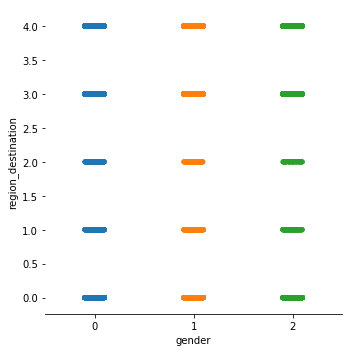

In [9]:
plt.figure(figsize=(10,6))
sns.catplot(data = users_who_booked, x='gender' , y='region_destination')
sns.despine(left=True)

In [10]:
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('gender')
    ax.set_ylabel('region')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    #plt.scatter(clustered['gender'], clustered['region_destination'], c=clustered['group'], s=20, cmap=cmap)
    


In [11]:
def add_cluster_to_dataset( original_df, predictions):
    return  pd.concat([original_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [12]:
# Let's turn our dataset into a list

X = users_who_booked [['gender','region_destination']].values

Comenzamos haciendo 2 grupos (k=2)

In [13]:
# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)


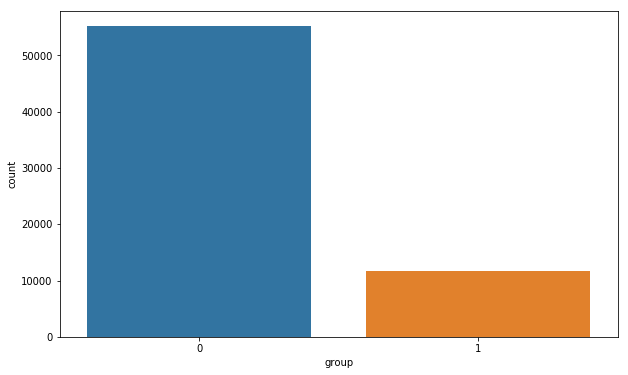

In [14]:
pred_df = pd.DataFrame({'group':predictions})
plt.figure(figsize=(10,6))
sns.countplot(data=pred_df, x='group')

In [15]:
k2_df = add_cluster_to_dataset(users_who_booked, predictions)
# Plot
#draw_clusters(users_who_booked, predictions)


KeyboardInterrupt: 

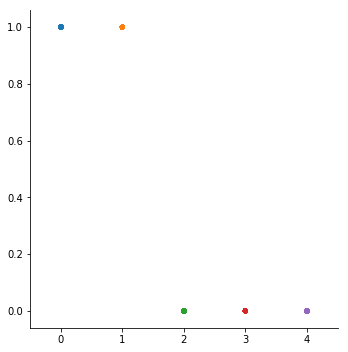

In [16]:
#sns.catplot(y="group", x="region_destination", kind="swarm", data=k2_df);

Parece que separó a los que fueron a USA y Europa por un lado  
y el resto de las regiones por otra...

In [17]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=3)

# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

predictions_3

array([0, 0, 2, ..., 1, 0, 0])

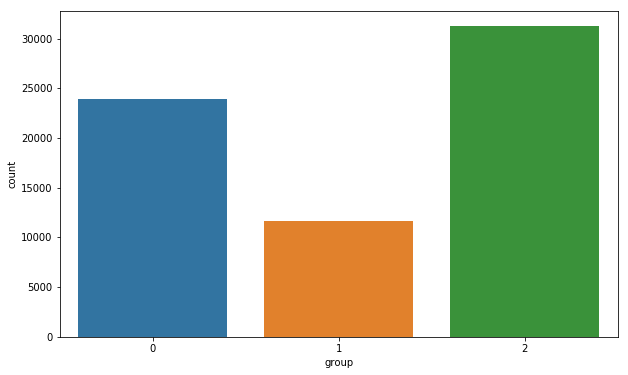

In [18]:
pred_df = pd.DataFrame({'group':predictions_3})
plt.figure(figsize=(10,6))
sns.countplot(data=pred_df, x='group')

In [26]:
k3_df = add_cluster_to_dataset(users_who_booked, predictions_3)
k3_df = pd.concat([users_who_booked.reset_index(), pd.DataFrame({'group':predictions_3})], axis=1)
k3_df.group.unique()


array([0, 2, 1], dtype=int64)

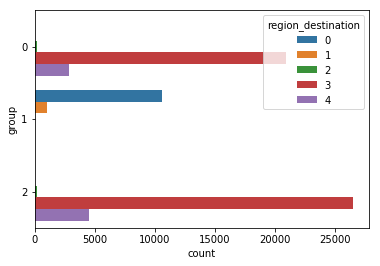

In [29]:
sns.countplot( y="group", hue='region_destination', data=k3_df);

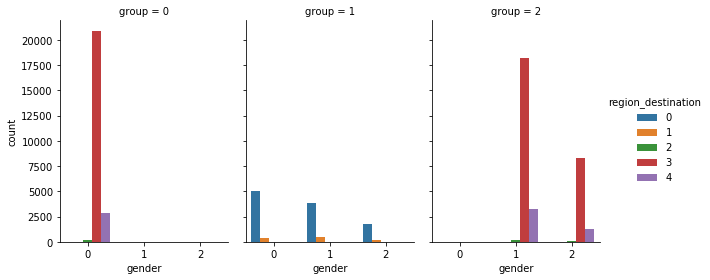

In [30]:
sns.catplot(x="gender", hue="region_destination", col="group",
            data=k3_df, kind="count",
            height=4, aspect=.7)

In [31]:
# Create an instance of KMeans to find 4 clusters
kmeans_4 = KMeans(n_clusters=4)

# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

predictions_4

array([1, 1, 0, ..., 2, 1, 1])

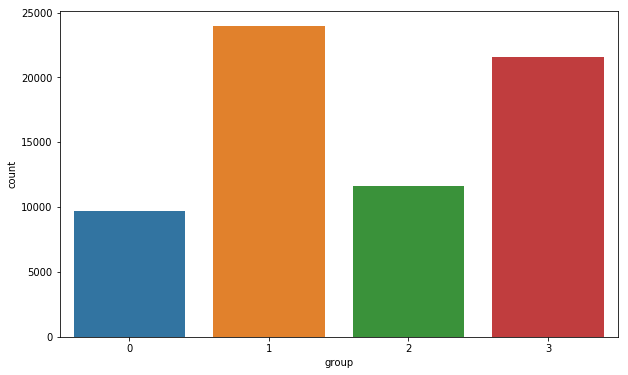

In [32]:
pred_df = pd.DataFrame({'group':predictions_4})
plt.figure(figsize=(10,6))
sns.countplot(data=pred_df, x='group')

In [33]:
k4_df = add_cluster_to_dataset(users_who_booked, predictions_4)
k4_df = pd.concat([users_who_booked.reset_index(), pd.DataFrame({'group':predictions_4})], axis=1)
k4_df.group.unique()


array([1, 0, 2, 3], dtype=int64)

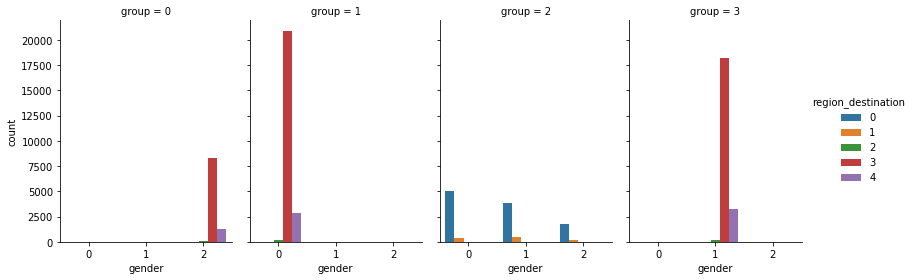

In [34]:
sns.catplot(x="gender", hue="region_destination", col="group",
            data=k4_df, kind="count",
            height=4, aspect=.7);